In [2]:
import glob
import sahi

from sahi import AutoDetectionModel
from sahi.predict import get_sliced_prediction
from sahi.utils.cv import read_image_as_pil

from matplotlib import pyplot as plt
import cv2
import pandas as pd
from ultralytics import YOLO

from sklearn.metrics import auc

In [3]:
from sahi.utils.yolov8 import (
    download_yolov8m_model,
)

from sahi import AutoDetectionModel
from sahi.utils.cv import read_image
from sahi.utils.file import download_from_url
from sahi.predict import get_prediction, get_sliced_prediction, predict
from IPython.display import Image

## Auxiliary functions

In [4]:
def intersection_over_union(gt, pred):
    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(gt[0], pred[0])
    yA = max(gt[1], pred[1])
    xB = min(gt[2], pred[2])
    yB = min(gt[3], pred[3])
    # if there is no overlap between predicted and ground-truth box
    if xB < xA or yB < yA:
        return 0.0
    # compute the area of intersection rectangle
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
    # compute the area of both the prediction and ground-truth
    # rectangles
    boxAArea = (gt[2] - gt[0] + 1) * (gt[3] - gt[1] + 1)
    boxBArea = (pred[2] - pred[0] + 1) * (pred[3] - pred[1] + 1)
    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the intersection area
    iou = interArea / float(boxAArea + boxBArea - interArea)
    # return the intersection over union value
    return iou

In [5]:
# download YOLOV8m model to 'models/yolov5s6.pt'
yolov8_model_path = "models/yolov8m.pt"
download_yolov8m_model(yolov8_model_path)

In [6]:
detection_model = AutoDetectionModel.from_pretrained(
    model_type='yolov8',
    model_path=yolov8_model_path,
    confidence_threshold=0.4,
    device="cuda:1", # or 'cuda:0'
)

In [101]:
predictions = get_prediction(read_image("people_frames/people_frames_1.jpg"), detection_model)

In [102]:
#results in form tlwh
results = predictions.to_coco_annotations()

In [72]:
image = cv2.imread("people_frames/people_frames_1.jpg")
height, width = image.shape[:2]

In [11]:
def xywh_tlbr(box):
    #get box (x_c, y_c, width, height) -> (tlbr)
    box[0]=box[0]-box[2]/2
    box[1]=box[1]-box[3]/2
    box[2]=box[0]+box[2]
    box[3]=box[1]+box[3]
    return box

In [12]:
def tlwh_tlbr(box):
    #get box (top left, width, height) -> (tlbr)
    box[2]=box[0]+box[2]
    box[3]=box[1]+box[3]
    return box

In [13]:
def scale_box(width, height, box):
    box[0]*=width
    box[2]*=width
    box[1]*=height
    box[3]*=height
    return box

### Unite all in one function

In [65]:
def compute_AP50(gt_path, predictions, image_path):
    '''
    compute AP50 for one image
    :param gt_path: path to GT labels
    :param predictions: predictions in coco format: tlwh
    :image_path: image - on which we compute predictions (need for width and height)
    :return: AP50
    '''

    image = cv2.imread(image_path)
    height, width = image.shape[:2]

    with open(gt_path, "r") as f:
        boxes= f.readlines()
    #gt boxes are in the format x_c, y_c, width, height
    gt_boxes = [box.split(" ")[1:] for box in boxes if box.split(" ")[0]=='0'] #select only people (class 0)
    gt_boxes = [list(map(lambda x: float(x.strip()), box)) for box in gt_boxes]
    #convert from xywh to tlbr
    gt_boxes = [xywh_tlbr(box) for box in gt_boxes]
    #multiply by the image height and width
    gt_boxes = [scale_box(width, height, box) for box in gt_boxes]


    #dataframe for saving results of IOU computing
    predicted_boxes = pd.DataFrame(columns=['image', 'confidence', 'iou', 'TP', 'FP', 'Precision', 'Recall'], index=range(len(results)))

    for i, result in enumerate(predictions):
        ious=[]
        if result['category_id']==0: #only person
            predicted_boxes.loc[i]['image'] = 'people_frames_1.jpg'
            predicted_boxes.loc[i]['confidence']=result['score']
            pr_box=result['bbox'].copy()
            pr_box=tlwh_tlbr(pr_box)
            for gt_box in gt_boxes:
                iou = intersection_over_union(gt_box, pr_box)
                ious.append(iou)
            if max(ious)>0.5:
                predicted_boxes.loc[i]['iou']=max(ious)
                predicted_boxes.loc[i]['TP']=1
                predicted_boxes.loc[i]['FP']=0
            else:
                predicted_boxes.loc[i]['iou']=max(ious)
                predicted_boxes.loc[i]['FP']=1
                predicted_boxes.loc[i]['TP']=0

    num_gt = len(gt_boxes)

    #compute precision and recall
    predicted_boxes.sort_values(by='confidence', ascending=False)
    for i, row in predicted_boxes.iterrows():
        predicted_boxes.loc[i]['Precision']=predicted_boxes[:i+1]['TP'].sum()/len(predicted_boxes[:i+1])
        predicted_boxes.loc[i]['Recall']=predicted_boxes[:i+1]['TP'].sum()/num_gt

    #plot predictions
    for result in predictions:
        pr_box=result['bbox'].copy()
        pr_box=tlwh_tlbr(pr_box)
        cv2.rectangle(image, (int(pr_box[0]), int(pr_box[1])), (int(pr_box[2]), int(pr_box[3])), color=(0, 255, 0), thickness=2)

    #plot ground truth
    for box in gt_boxes:
        cv2.rectangle(image, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), color=(255, 0, 0), thickness=2)
    plt.imshow(image)
    plt.axis('off')
    plt.show()


    plt.figure(figsize=(9, 4))
    plt.plot(predicted_boxes['Recall'], predicted_boxes['Precision'])
    plt.title("Precision-Recall curve")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.show()

    ap50 = auc(predicted_boxes['Recall'], predicted_boxes['Precision'])
    print(f"AP50 = {ap50 :.4f}")



### Get usual predictions

In [66]:
predictions = get_prediction(read_image("people_frames/people_frames_1.jpg"), detection_model)
#results in form tlwh
results = predictions.to_coco_annotations()

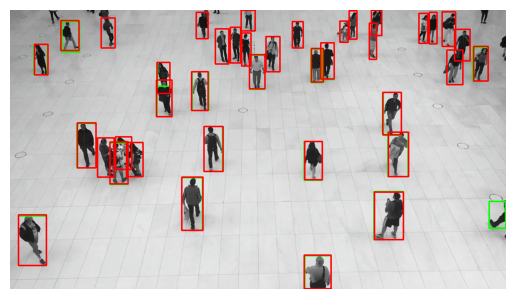

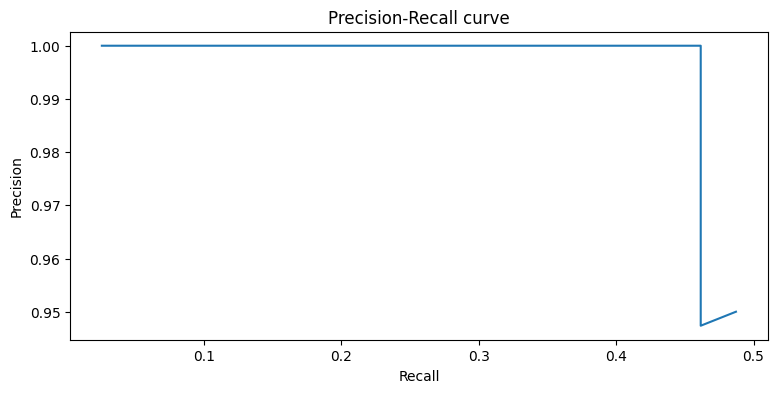

AP50 = 0.4602


In [67]:
compute_AP50("datasets/labels/people_frames_1.txt", results, "people_frames/people_frames_1.jpg")

## Get sliced predictions

In [33]:
result = get_sliced_prediction(
    "people_frames/people_frames_1.jpg",
    detection_model,
    slice_height = 512,
    slice_width = 512,
    overlap_height_ratio = 0.2,
    overlap_width_ratio = 0.2
)

Performing prediction on 6 number of slices.


In [34]:
results = result.to_coco_annotations()

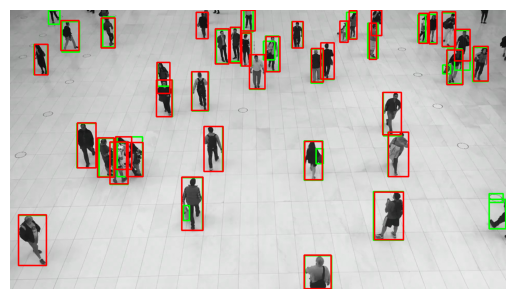

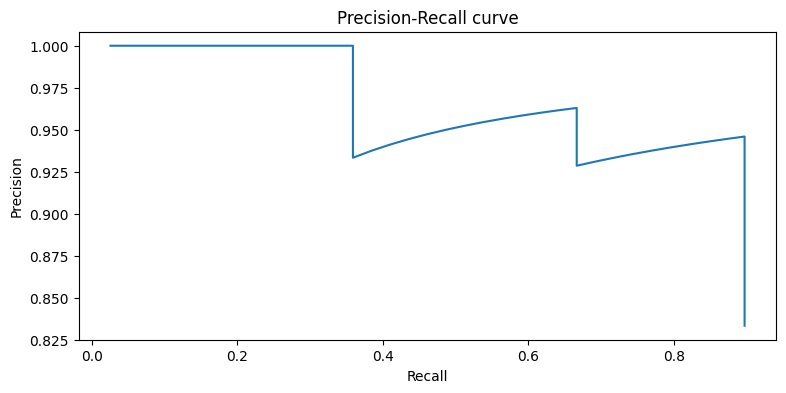

AP50 = 0.8424


In [18]:
compute_AP50("datasets/labels/people_frames_1.txt", results, "people_frames/people_frames_1.jpg")

In [70]:
def make_prediction(image_dir, destination_dir):

    for image in glob.glob(f"{image_dir}/*.jpg"):

        predictions = get_sliced_prediction(
        image,
        detection_model,
        slice_height = 512,
        slice_width = 512,
        overlap_height_ratio = 0.2,
        overlap_width_ratio = 0.2
        )

        file_name = image.split("/")[-1].split(".")[0]

        results = predictions.to_coco_annotations()

        with open(f"{destination_dir}/{file_name}.txt", "w+") as f:
            for result in results:
                f.write(str(result['category_id'])+" ")
                f.write(" {:.8f}".format(result['score']))
                for box in result['bbox']:
                    f.write(" {:.8f}".format(box))
                f.write("\n")


In [71]:
make_prediction("datasets/images", "sliced_results")

Performing prediction on 6 number of slices.
Performing prediction on 6 number of slices.
Performing prediction on 6 number of slices.
Performing prediction on 6 number of slices.
Performing prediction on 6 number of slices.
Performing prediction on 6 number of slices.
Performing prediction on 6 number of slices.
Performing prediction on 6 number of slices.
Performing prediction on 6 number of slices.
Performing prediction on 6 number of slices.
Performing prediction on 6 number of slices.
Performing prediction on 6 number of slices.
Performing prediction on 6 number of slices.
Performing prediction on 6 number of slices.
Performing prediction on 6 number of slices.
Performing prediction on 6 number of slices.
Performing prediction on 6 number of slices.
Performing prediction on 6 number of slices.
Performing prediction on 6 number of slices.
Performing prediction on 6 number of slices.
Performing prediction on 6 number of slices.
Performing prediction on 6 number of slices.
Performing

In [119]:
def compute_AP50_all(gt_dir, predictions_dir, image_dir):
    '''
    compute AP50 for batch of images
    :param gt_path: path to GT labels
    :param predictions: predictions in coco format: tlwh
    :image_path: image - on which we compute predictions (need for width and height)
    :return: AP50
    '''

    #dataframe for saving results of IOU computing
    predicted_boxes = pd.DataFrame(columns=['image', 'confidence', 'iou', 'TP', 'FP', 'Precision', 'Recall'], index=range(10000))

    num_gt=0
    i=0

    for image_path in glob.glob(f"{image_dir}/*.jpg"):

        print(image_path)

        image = cv2.imread(image_path)
        height, width = image.shape[:2]

        file_name = image_path.split("/")[-1].split(".")[0]

        gt_path = f"{gt_dir}/{file_name}.txt"

        with open(gt_path, "r") as f:
            boxes= f.readlines()

        #gt boxes are in the format x_c, y_c, width, height
        gt_boxes = [box.split(" ")[1:] for box in boxes if box.split(" ")[0]=="0"] #only people
        gt_boxes = [list(map(lambda x: float(x.strip()), box)) for box in gt_boxes]
        #convert from xywh to tlbr
        gt_boxes = [xywh_tlbr(box) for box in gt_boxes]
        #multiply by the image height and width
        gt_boxes = [scale_box(width, height, box) for box in gt_boxes]


        predictions_path = f"{predictions_dir}/{file_name}.txt"

        with open(predictions_path, "r") as f:
            predictions = f.readlines()
        for result in predictions:
            prediction = result.split(" ")
            #print(prediction)
            category_id = prediction[0]
            ious=[]
            if category_id=='0': #only person
                predicted_boxes.loc[i]['image'] = file_name
                predicted_boxes.loc[i]['confidence']=float(prediction[2])
                pr_box=list(map(lambda x: float(x.strip()), prediction[3:].copy()))
                pr_box=tlwh_tlbr(pr_box)
                print(pr_box)
                for gt_box in gt_boxes:
                    iou = intersection_over_union(gt_box, pr_box)
                    ious.append(iou)
                if max(ious)>0.5:
                    predicted_boxes.loc[i]['iou']=max(ious)
                    predicted_boxes.loc[i]['TP']=1
                    predicted_boxes.loc[i]['FP']=0
                else:
                    predicted_boxes.loc[i]['iou']=max(ious)
                    predicted_boxes.loc[i]['FP']=1
                    predicted_boxes.loc[i]['TP']=0
                i+=1
            else:
                continue

        num_gt += len(gt_boxes)

    #compute precision and recall
    predicted_boxes.sort_values(by='confidence', ascending=False)

    predicted_boxes=predicted_boxes.dropna(axis=1)


    for i, row in predicted_boxes.iterrows():
        predicted_boxes.loc[i]['Precision']=predicted_boxes.loc[:i+1]['TP'].sum()/len(predicted_boxes[:i+1])
        predicted_boxes.loc[i]['Recall']=predicted_boxes.loc[:i+1]['TP'].sum()/num_gt



    #plot predictions
        # for result in predictions:
        #     pr_box=result['bbox'].copy()
        #     pr_box=tlwh_tlbr(pr_box)
        #     cv2.rectangle(image, (int(pr_box[0]), int(pr_box[1])), (int(pr_box[2]), int(pr_box[3])), color=(0, 255, 0), thickness=2)

        # #plot ground truth
        # for box in gt_boxes:
        #     cv2.rectangle(image, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), color=(255, 0, 0), thickness=2)
        # plt.imshow(image)
        # plt.axis('off')
        # plt.show()


    plt.figure(figsize=(9, 4))
    plt.plot(predicted_boxes['Recall'], predicted_boxes['Precision'])
    plt.title("Precision-Recall curve")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.show()

    ap50 = auc(predicted_boxes['Recall'], predicted_boxes['Precision'])
    print(f"AP50 = {ap50 :.4f}")

    return predicted_boxes


In [120]:
data = compute_AP50_all("datasets/labels", "sliced_results", "datasets/images")

datasets/images/people_frames_88.jpg
[817.36932373, 340.70178223, 863.5713501, 438.67218018]
[0.0, 266.22207642, 41.9248848, 361.83700562]
[819.35748291, 425.55435181, 873.8154907200001, 530.8838501]
[591.45721436, 440.43347168, 638.1707306, 540.0]
[60.87747955, 395.28543091, 112.8990097, 482.14022827]
[532.36865234, 417.70367432, 574.4036560000001, 515.52471924]
[333.68023682, 469.24081421, 387.3147583, 539.7774353]
[499.46231079, 377.34310913, 534.22076416, 461.92962646]
[528.33860779, 263.0670166, 567.79966736, 345.2086792]
[828.18109131, 190.61462402, 863.46972656, 272.47460937]
[43.66265106, 56.93855667, 68.39694214, 116.86455536]
[554.11529541, 85.71146393, 579.13995361, 143.84112549]
[454.70523834, 170.16416931, 488.96551512999997, 244.44442749]
[880.54550171, 113.56082153, 915.19473267, 192.16232299]
[76.43006897, 26.57941246, 111.61952972, 78.33072662000001]
[83.66256714, 478.12322998, 138.42991638, 540.0]
[903.6628418, 165.69198608, 944.65063477, 247.02999877999997]
[282.9240

KeyError: 'TP'

In [118]:
data

,image,confidence,iou,TP,FP,Precision,Recall
0,people_frames_62,0.901911,0.249773,0,1,0.0,0.0
1,people_frames_62,0.883356,0.0,0,1,0.0,0.0
2,people_frames_62,0.883036,0.197162,0,1,0.0,0.0
3,people_frames_62,0.877199,0.006273,0,1,0.0,0.0
4,people_frames_62,0.873131,0.0,0,1,0.0,0.0
...,...,...,...,...,...,...,...
995,NaN,NaN,NaN,NaN,NaN,0.00502,0.001315
996,NaN,NaN,NaN,NaN,NaN,0.005015,0.001315
997,NaN,NaN,NaN,NaN,NaN,0.00501,0.001315
998,NaN,NaN,NaN,NaN,NaN,0.005005,0.001315
